In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Dataset Shape: (8936, 2)
                                    property_address   categories
0  New Ppid 1Kqttmg7, House, Property Id No.58C57...  houseorplot
1  Property Of Rs No.12/2,Plot No. 01,House Numbe...  houseorplot
2  Flat-504,Floor-5 Shanti Vista-Ii Wing C Bldg 9...         flat
3  Flat-103,Floor-1 Eshamya Florenza Tower L S No...         flat
4  Flat No G 532 I P Extension Patparganj 2Nd Flo...         flat


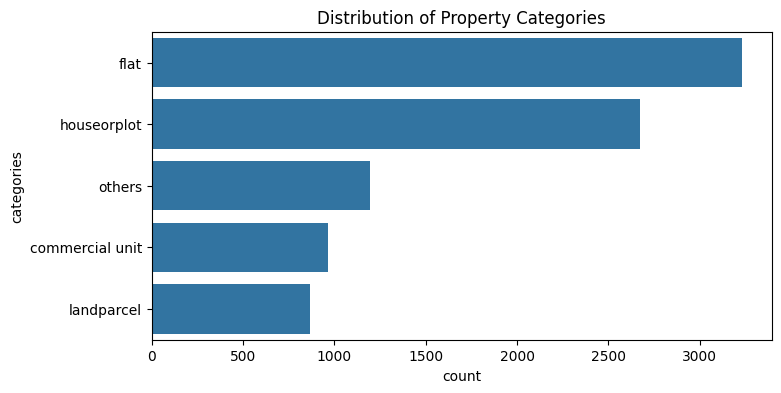

property_address    0
categories          0
dtype: int64


In [2]:
df = pd.read_csv('C:\\Users\\Gowtham\\property-addresses\\task_dataset - training_dataset.csv')

print("Dataset Shape:", df.shape)
print(df.head())

# CHECKING FOR CLASS IMBALANCE
plt.figure(figsize=(8,4))
sns.countplot(y=df['categories'], order=df['categories'].value_counts().index)
plt.title("Distribution of Property Categories")
plt.show()

# CHECKING FOR MISSING VALUES
print(df.isnull().sum())
df = df.dropna(subset=['property_address', 'categories']) # Drop missing rows

In [3]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Removes special characters but KEEP numbers 
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 3. Removes extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applying cleaning
df['cleaned_address'] = df['property_address'].apply(clean_text)

print("Before:", df['property_address'].iloc[0])
print("After: ", df['cleaned_address'].iloc[0])

Before: New Ppid 1Kqttmg7, House, Property Id No.58C57U54 Having Land Measuring 200 Sq.Yd Situated At Vaka Jasico Colony, Jagadhri, And Distt. Yamunanagar Inside Mc Limits, Tehsil Jagadhri Near Mandir
After:  new ppid 1kqttmg7 house property id no 58c57u54 having land measuring 200 sq yd situated at vaka jasico colony jagadhri and distt yamunanagar inside mc limits tehsil jagadhri near mandir


In [4]:
X = df['cleaned_address']
y = df['categories']

# 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 7148
Validation samples: 1788


In [5]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english')),
    ('clf', LinearSVC(class_weight='balanced', random_state=42))
])

# Train the model
print("Training model...")
pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


### Classification Report ###
                 precision    recall  f1-score   support

commercial unit       0.95      0.94      0.95       193
           flat       0.96      0.94      0.95       647
    houseorplot       0.87      0.85      0.86       535
     landparcel       0.73      0.75      0.74       174
         others       0.76      0.83      0.79       239

       accuracy                           0.88      1788
      macro avg       0.85      0.86      0.86      1788
   weighted avg       0.88      0.88      0.88      1788



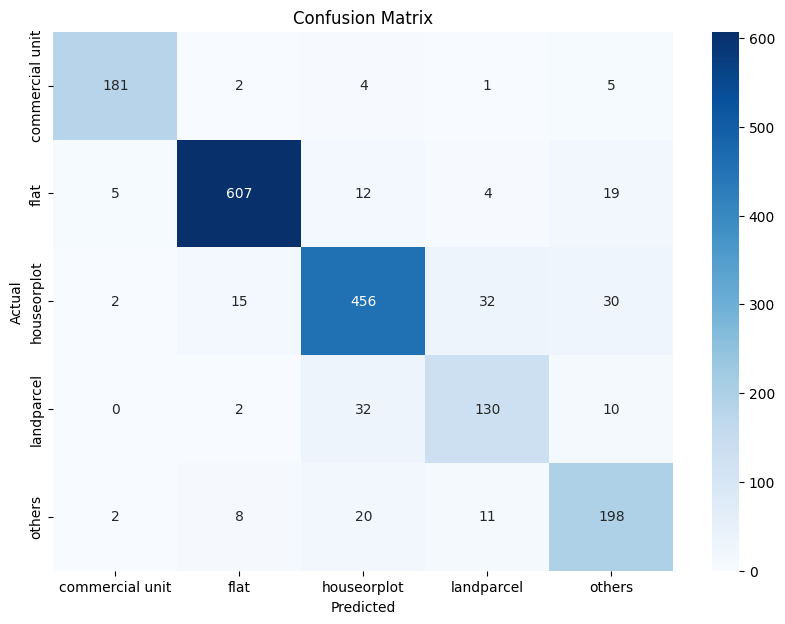

In [6]:
# Predicting on validation set
y_pred = pipeline.predict(X_val)

# 1. Classification Report
print("### Classification Report ###")
print(classification_report(y_val, y_pred))

# 2. Confusion Matrix Visualization
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_val, y_pred, labels=pipeline.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
import os

# Created a folder for the model
if not os.path.exists('best_model'):
    os.makedirs('best_model')

# Saving the entire pipeline (includes both the vectorizer and the model)
joblib.dump(pipeline, 'best_model/property_classifier_pipeline.pkl')

print("Model saved successfully in 'best_model' folder.")

Model saved successfully in 'best_model' folder.


In [9]:
import joblib
import re
import sys
import warnings

def predict_category(address):
    # Load model
    model = joblib.load('best_model/property_classifier_pipeline.pkl')
    # Predict
    prediction = model.predict([address])[0]
    return prediction

# Test with custom examples
test_addresses = [
    "Flat no 405, Galaxy Apartments, MG Road",
    "Plot 22, Industrial Area, Phase 1",
    "Open land near highway, survey number 20"
]

print("--- Inference Test ---")
for addr in test_addresses:
    print(f"Address: {addr}  ->  Prediction: {predict_category(addr)}")

--- Inference Test ---
Address: Flat no 405, Galaxy Apartments, MG Road  ->  Prediction: flat
Address: Plot 22, Industrial Area, Phase 1  ->  Prediction: houseorplot
Address: Open land near highway, survey number 20  ->  Prediction: landparcel
